# Title
and Summary

## Data Overview

notes

In [1]:
# !pip install utm # Ran once

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6109 sha256=97b05bd3b4c05b1be5241244705079469fca93953f96d32ce3bd7b7faa6c30af
  Stored in directory: /home/exouser/.cache/pip/wheels/75/f0/dd/39dfc9436520412399934d4a8566fe5c0cb8cc2568a1196057
Successfully built utm


In [1]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
import imageio.plugins.ffmpeg as ffmpeg

Load and process data (there's an error printed, but I think it might be fine)

In [2]:
#Loading the data and splitting it in testing and training data
from io import StringIO
import numpy as np
import csv
import math
import utm
import os

from sklearn.model_selection import train_test_split

# Cue up folders to check (MODIFY with addition or removal of folders)
data_folders = ['r3/','r4/','s1/']

# Sets to be filled
labels = []
images = []

# Check each folder in cue
for folder in data_folders:

    # Load image filenames
    img_path = './data/' + folder
    img_filenames = os.listdir(img_path)

    # Load CSV data
    csv_path = img_path + "/im_info.csv"
    with open(csv_path, 'r') as x:
        csv_data = list(csv.reader(x, delimiter=","))

    # Load data into np array and delete title row element
    csv_data = np.array(csv_data)
    csv_data = np.delete(csv_data,0)
    
    # Begin formatting data
    print('Formatting Data for', folder ,'...')
    print('Number of datapoints:', len(csv_data))

    for i in range(0,len(csv_data)-2):
        # Load image
        image = img_path+img_filenames[i]
        # Load current data and data 1/3s into future (for next imgage)
        # Vals loaded from each line are [timestamp, yaw, lat, lon]
        curr_line = csv_data[i]
        curr_vals =  np.float_([curr_line[1],curr_line[4],curr_line[6],curr_line[7]])
        next_line = csv_data[i+1]
        next_vals =  np.float_([next_line[1],next_line[4],next_line[6],next_line[7]])
    
        curr_coord = utm.from_latlon(curr_vals[2], curr_vals[3])
        next_coord = utm.from_latlon(next_vals[2], next_vals[3])
    
        time_change = next_vals[0] - curr_vals[0] # change in time (may be unused)
        angle_change = next_vals[1] - curr_vals[1] # change that should be commanded to current steering angle
        # distance_change = abs(math.dist([curr_vals[2],curr_vals[3]],[next_vals[2],next_vals[3]])) # NOTE - this is lat/lon so values are small
        distance_change = abs(math.dist([curr_coord[0],curr_coord[1]],[next_coord[0],next_coord[1]]))
        velocity = distance_change/time_change # velocity that should be commanded
    
        label = [angle_change, velocity] # angle change is in degrees (I think), velocity units are __
    
        images.append(image)
        labels.append(label)


data_images = np.array(images)
data_labels = np.array(labels)

print('Formatting Complete')
print('=============================')

# Split data into training and testing sets
img_train, img_test, label_train, label_test = train_test_split(data_images, data_labels, test_size=0.2, random_state=42)

# Print the size of the resulting datasets
print(f"Training image data size: {len(img_train)}")
print(f"Testing image data size: {len(img_test)}")
print(f"Training label data size: {len(label_train)}")
print(f"Testing label data size: {len(label_test)}")

/tmp/ipykernel_2891/811119259.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  csv_data = np.array(csv_data)


Formatting Data for r3/ ...
Number of datapoints: 544
Formatting Data for r4/ ...
Number of datapoints: 524
Formatting Data for s1/ ...
Number of datapoints: 581
Formatting Complete
Training image data size: 1314
Testing image data size: 329
Training label data size: 1314
Testing label data size: 329


Load an image and check out labeling

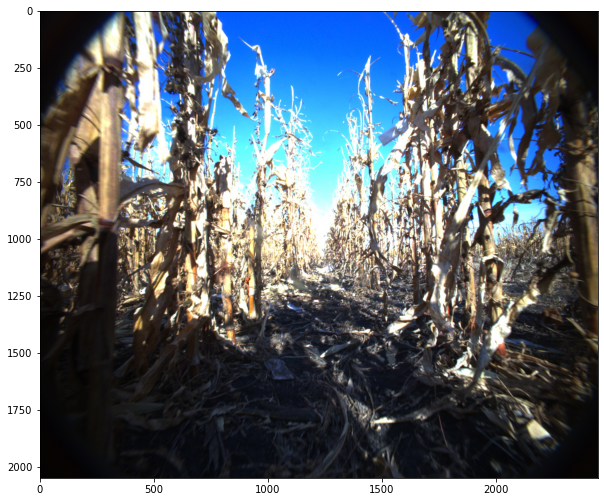

Steering Change to Make: -1.2477696918229748 | Velocity to Command: 1.1773821324110856


In [3]:
import random

# Select a random image from the list
img_rand = random.randint(0,len(img_train))

image = img_train[img_rand]

label = label_train[img_rand]

# Load the image using matplotlib
img = mpimg.imread(image)

# Display the image
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

# Print label
print('Steering Change to Make:',label[0], '| Velocity to Command:', label[1])

Prepare custom dataloader

In [4]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from PIL import Image

class MaizeRoverDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.labels = labels
        self.images = images
        self.transform = transform        
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        img_path = self.images[idx] # './data/IMG_data/' + self.images[idx]
        image = Image.open(img_path)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label



## Define CNNs for training

Below CNN was developed for HW3 Rover Problem

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


class MaizeRoverCNN_Simple(nn.Module):
    def __init__(self):
        super(MaizeRoverCNN_Simple, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 6) #in channels, out channels, kernel size, stride (opt.)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 4) # unused currently
        self.fc1 = nn.Linear(739600, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        # x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        x = torch.flatten(x,1) # flatten or view??
        
        x = F.relu(self.fc1(x)) # Change shape for fc layers
        x = F.relu(self.fc2(x))
        x = self.fc3(x)      
        return x


<function matplotlib.pyplot.show(close=None, block=None)>

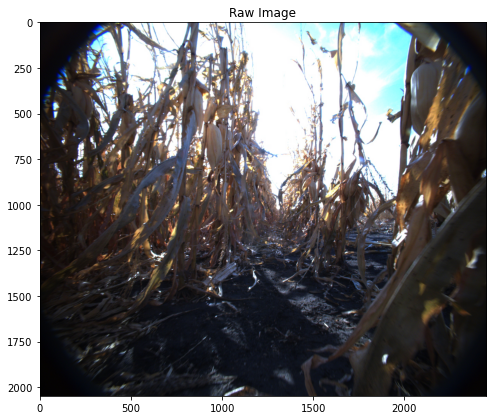

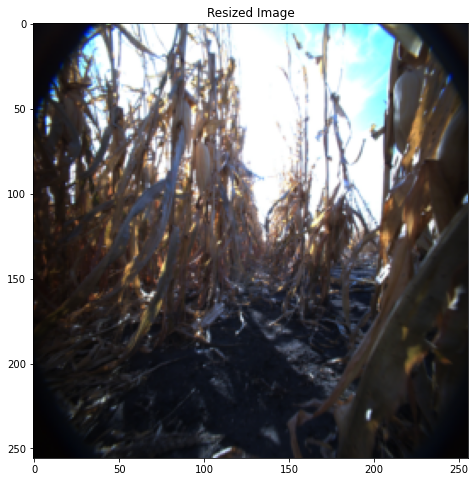

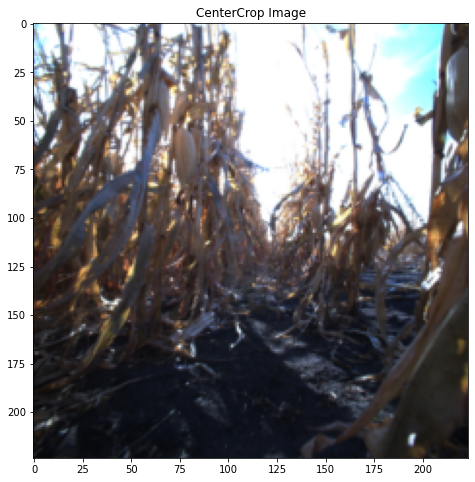

In [11]:
# TRANFORM TESTING (MAY DELETE LATER!!)
import torch
import torchvision
from PIL import Image
# !pip install torchvision
from torchvision import datasets, transforms
# from torchvision import datapoints

# Select a random image from the list
img_rand = random.randint(0,len(img_train))
image_path = img_train[img_rand]

image = Image.open(image_path)

# Raw Image
fig = plt.figure(figsize=(8,8))
plt.imshow(image)
plt.title('Raw Image')
plt.show

# First Transform
transform=transforms.Compose([
            transforms.Resize((256,256))])

fig = plt.figure(figsize=(8,8))
plt.imshow(transform(image))
plt.title('Resized Image')
plt.show

# Second Transform
transform=transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224)])
            # transforms.ToTensor()])

fig = plt.figure(figsize=(8,8))
plt.imshow(transform(image))
plt.title('CenterCrop Image')
plt.show

In [13]:
# PAREMETERS FOR MODEL TRAINING
BATCH_SIZE = 32
EPOCHS = 5

# TRAINING AND VALIDATION SPLIT
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

#Define image transform used
transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()]) 

In [16]:
#Load Training and Testing Data
from torch.utils.data import DataLoader
from torch.utils.data import random_split
           
# load datasets
training_data = MaizeRoverDataset(img_train, label_train, transform)
test_data = MaizeRoverDataset(img_test, label_test, transform)

# do train/validation split
numTrainSamples = int(len(training_data) * TRAIN_SPLIT)
numValSamples = int(len(training_data) * VAL_SPLIT)
(training_data, val_data) = random_split(training_data, 
                                    [numTrainSamples, numValSamples],
                                    generator=torch.Generator().manual_seed(42))

# New data loaders
train_loader =  DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader =  DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# calculate steps per epoch for training and validation set
trainSteps = len(train_loader.dataset) // BATCH_SIZE
valSteps = len(val_loader.dataset) // BATCH_SIZE

ValueError: Sum of input lengths does not equal the length of the input dataset!